In [1]:
import cv2
import numpy as np
import openslide
import xml.etree.ElementTree as ET
from pathlib import Path
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
# ============================================================
# 1) Magnification utilities
# ============================================================
def _objective_power(slide):
    for k in (
        "openslide.objective-power",
        "aperio.AppMag",
        "hamamatsu.XObjective",
    ):
        if k in slide.properties:
            try:
                return float(slide.properties[k])
            except Exception:
                pass
    return None


def pick_level_for_target_mag(slide, target_mag, default_base=40.0):
    base_mag = _objective_power(slide) or default_base
    desired_down = base_mag / float(target_mag)

    downs = list(slide.level_downsamples)
    lvl = int(np.argmin([abs(d - desired_down) for d in downs]))

    used_down = downs[lvl]
    scale_img = used_down / desired_down
    return lvl, scale_img, base_mag

In [3]:
# ============================================================
# 2) XML -> full semantic mask map at chosen mask base resolution
# ============================================================
def rasterize_xml_mask(xml_path, slide, layer_ids):
    downsample = int(BASE_MAG / MASK_BASE_MAG)  # 40 / 2.5 = 16
    W0, H0 = slide.level_dimensions[0]
    Hm, Wm = H0 // downsample, W0 // downsample

    masks = {lid: np.zeros((Hm, Wm), np.uint8) for lid in layer_ids}

    tree = ET.parse(str(xml_path))
    root = tree.getroot()

    for anno in root.iter("Annotation"):
        lid = int(anno.attrib.get("Id", -1))
        if lid not in layer_ids:
            continue

        for region in anno.iter("Region"):
            pts = []
            for v in region.iter("Vertex"):
                x = int(float(v.attrib["X"]) / downsample)
                y = int(float(v.attrib["Y"]) / downsample)
                pts.append((x, y))

            if len(pts) >= 3:
                cnt = np.array(pts, np.int32).reshape((-1, 1, 2))
                cv2.fillPoly(masks[lid], [cnt], 1)

    return masks

In [4]:
# ============================================================
# 3) Visualization slide
# ============================================================
def visualize_patch_boxes_lowmag(
    rgb_mask,
    xy_mask,
    patch_mask,
    max_boxes=300,
    random_sample=True,
    figsize=(10, 8),
):
    if random_sample and len(xy_mask) > max_boxes:
        xy_mask = random.sample(xy_mask, max_boxes)

    fig, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(rgb_mask)
    ax.axis("off")

    for (x, y) in xy_mask:
        rect = patches.Rectangle(
            (x, y),
            patch_mask,
            patch_mask,
            linewidth=0.5,
            edgecolor="red",
            facecolor="none",
        )
        ax.add_patch(rect)
    ax.set_title(f"Low-mag patch coverage ({len(xy_mask)})")
    plt.show()

# Glomerulus

In [6]:
def main():
    # =========================
    # CONFIG
    #   Glom segmentation (dataset/Annotation/Glmerulus)
    #     Id == 1 -> Core ROI
    #     Id == 2 -> Glomerulus
    # =========================
    MAG_TO_LEVEL = {
    40.0: 0,
    10.0: 1,
    2.5:  2,
    }
    SVS_DIR = Path("/home/khdp-user/workspace/dataset/Slide")
    XML_DIR = Path("/home/khdp-user/workspace/dataset/Annotation/Glomerulus")
    OUT_DIR = Path("/home/khdp-user/workspace/Glom_patch")
    BASE_MAG      = 40.0
    PATCH_SIZE    = 512
    STRIDE        = 512
    TARGET_MAG    = 10.0
    MASK_BASE_MAG = 2.5
    OVERLAP_TH    = 0.05
    LAYER_IDS = [2]
    VISUALIZE_FIRST = True
    OUT_DIR.mkdir(parents=True, exist_ok=True)
    xml_list = sorted(XML_DIR.glob("*.xml"))
    if len(xml_list) == 0:
        raise RuntimeError("No XML files found.")
    ALLOWED_MAGS = set(MAG_TO_LEVEL.keys())
    if TARGET_MAG not in ALLOWED_MAGS:
        raise ValueError(
            f"TARGET_MAG={TARGET_MAG} is not supported. "
            f"Allowed magnifications: {sorted(ALLOWED_MAGS)}"
        )
    
    if MASK_BASE_MAG not in ALLOWED_MAGS:
        raise ValueError(
            f"MASK_BASE_MAG={MASK_BASE_MAG} is not supported. "
            f"Allowed magnifications: {sorted(ALLOWED_MAGS)}"
        )
    # =========================
    # XML → SVS loop
    # =========================
    for xml_path in tqdm(xml_list, desc="slides(xml)"):

        svs_path = SVS_DIR / f"{xml_path.stem}.svs"
        if not svs_path.exists():
            continue

        name_ = svs_path.stem[:14]
        slide = openslide.OpenSlide(str(svs_path))

        # -------------------------
        # magnification
        # -------------------------
        lvl_img, scale_img, BASE_MAG = pick_level_for_target_mag(slide, TARGET_MAG)

        # -------------------------
        # mask base grid
        # -------------------------
        downsample = int(round(BASE_MAG / MASK_BASE_MAG))
        W0, H0 = slide.level_dimensions[0]
        mask_shape = (H0 // downsample, W0 // downsample)

        # -------------------------
        # XML → layer별 mask
        # -------------------------
        layer_masks = rasterize_xml_to_layer_masks(
            xml_path=xml_path,
            mask_shape=mask_shape,
            layer_ids=LAYER_IDS,
            downsample=downsample,
        )

        union_mask = np.zeros(mask_shape, np.uint8)
        for lid in LAYER_IDS:
            union_mask |= layer_masks[lid]

        Hm, Wm = union_mask.shape

        # -------------------------
        # output dirs
        # -------------------------
        slide_dir = OUT_DIR / name_
        img_dir   = slide_dir / "images"
        mask_root = slide_dir / "masks"

        img_dir.mkdir(parents=True, exist_ok=True)
        for lid in LAYER_IDS:
            (mask_root / f"layer{lid}").mkdir(parents=True, exist_ok=True)

        # -------------------------
        # patch loop
        # -------------------------
        xy_list = []
        stride_mask = int(round(STRIDE * (MASK_BASE_MAG / TARGET_MAG)))
        patch_mask_size = int(round(PATCH_SIZE * (MASK_BASE_MAG / TARGET_MAG)))
        for y in range(0, Hm, stride_mask):
            for x in range(0, Wm, stride_mask):
                if x + patch_mask_size >= Wm or y + patch_mask_size >= Hm:
                    continue
                patch_union = union_mask[y:y+patch_mask_size, x:x+patch_mask_size]
                overlap = np.count_nonzero(patch_union) / patch_union.size

                if overlap < OVERLAP_TH:
                    continue

                xy_list.append((x, y))

                x0 = x * downsample
                y0 = y * downsample

                req = int(round(PATCH_SIZE * scale_img))
                region = slide.read_region((x0, y0), lvl_img, (req, req))

                img = cv2.resize(
                    np.array(region)[:, :, :3],
                    (PATCH_SIZE, PATCH_SIZE),
                    interpolation=cv2.INTER_LINEAR,
                )

                out_name = f"{name_}_X0Y0_{x0:06d}_{y0:06d}.png"

                cv2.imwrite(
                    str(img_dir / out_name),
                    cv2.cvtColor(img, cv2.COLOR_RGB2BGR),
                )
                # layer별 mask 저장
                for lid in LAYER_IDS:
                    mp = layer_masks[lid][y:y+patch_mask_size, x:x+patch_mask_size]
                    if TARGET_MAG != MASK_BASE_MAG:
                        mp = cv2.resize(
                            mp,
                            (PATCH_SIZE, PATCH_SIZE),
                            interpolation=cv2.INTER_NEAREST,
                        )

                    if np.count_nonzero(mp) == 0:
                        continue

                    cv2.imwrite(
                        str(mask_root / f"layer{lid}" / out_name),
                        (mp * 255).astype(np.uint8),
                    )

        if VISUALIZE_FIRST and len(xy_list) > 0:
            lvl_vis = min(lvl_img + 2, slide.level_count - 1)
            Wv, Hv = slide.level_dimensions[lvl_vis]

            rgb_mask = np.array(
                slide.read_region((0, 0), lvl_vis, (Wv, Hv))
            )[:, :, :3]

            xy_vis = []
            for (x_mask, y_mask) in xy_list:
                x_lv0 = x_mask * downsample
                y_lv0 = y_mask * downsample
                x_vis = int(x_lv0 / slide.level_downsamples[lvl_vis])
                y_vis = int(y_lv0 / slide.level_downsamples[lvl_vis])
                xy_vis.append((x_vis, y_vis))

            patch_vis = int(
                (patch_mask_size * downsample) / slide.level_downsamples[lvl_vis]
            )
            visualize_patch_boxes_lowmag(
                rgb_mask=rgb_mask,
                xy_mask=xy_vis,
                patch_mask=patch_vis,
            )

            VISUALIZE_FIRST = False

        slide.close()

    print("[DONE] All slides processed.")

if __name__ == "__main__":
    main()

slides(xml):   0%|          | 0/764 [00:00<?, ?it/s]


NameError: name 'rasterize_xml_to_layer_masks' is not defined

# IFTA, Medulla, Extrarenal tissue & capsule extraction

slides(xml):   0%|          | 0/100 [00:00<?, ?it/s]

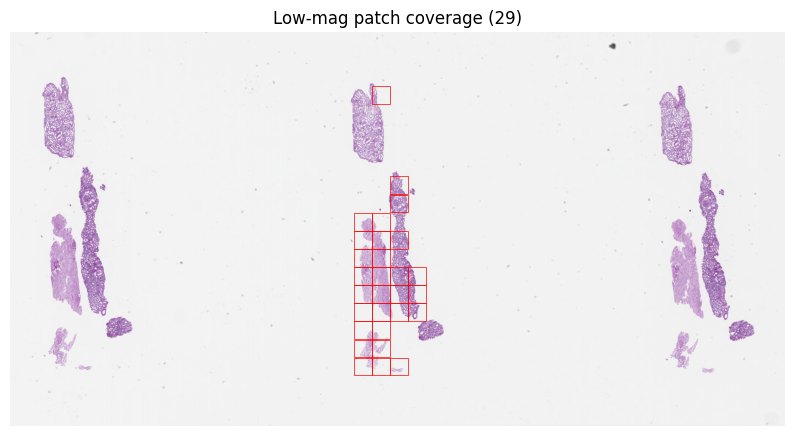

slides(xml): 100%|██████████| 100/100 [02:56<00:00,  1.77s/it]

[DONE] All slides processed.


In [29]:
def main():
    # =========================
    # CONFIG
    #   segmentation annotation info
    #   IFTA & Excluded ROI (dataset/Annotation/IFTA_Exception)
    #     Id == 1 -> IFTA 
    #     Id == 2 -> Medulla (Excluded ROI)
    #     Id == 3 -> Extrarenal tissue & capsule (Excluded ROI)
    #     Id == 4 -> Core ROI
    #     Id == 5 -> IFTA control
    # =========================
    MAG_TO_LEVEL = {
    40.0: 0,
    10.0: 1,
    2.5:  2,
    }
    SVS_DIR = Path("/home/khdp-user/workspace/dataset/Slide")
    XML_DIR = Path("/home/khdp-user/workspace/dataset/Annotation/IFTA_Exception")
    OUT_DIR = Path("/home/khdp-user/workspace/IFTA_patch")
    BASE_MAG      = 40.0
    PATCH_SIZE    = 512
    STRIDE        = 512
    TARGET_MAG    = 10.0
    MASK_BASE_MAG = 2.5
    OVERLAP_TH    = 0.05
    LAYER_IDS = [1,2,3]
    VISUALIZE_FIRST = True
    OUT_DIR.mkdir(parents=True, exist_ok=True)
    xml_list = sorted(XML_DIR.glob("*.xml"))
    if len(xml_list) == 0:
        raise RuntimeError("No XML files found.")
    ALLOWED_MAGS = set(MAG_TO_LEVEL.keys())
    if TARGET_MAG not in ALLOWED_MAGS:
        raise ValueError(
            f"TARGET_MAG={TARGET_MAG} is not supported. "
            f"Allowed magnifications: {sorted(ALLOWED_MAGS)}"
        )
    
    if MASK_BASE_MAG not in ALLOWED_MAGS:
        raise ValueError(
            f"MASK_BASE_MAG={MASK_BASE_MAG} is not supported. "
            f"Allowed magnifications: {sorted(ALLOWED_MAGS)}"
        )
    # =========================
    # XML → SVS loop
    # =========================
    for xml_path in tqdm(xml_list, desc="slides(xml)"):

        svs_path = SVS_DIR / f"{xml_path.stem}.svs"
        if not svs_path.exists():
            continue

        name_ = svs_path.stem[:14]
        slide = openslide.OpenSlide(str(svs_path))

        # -------------------------
        # magnification
        # -------------------------
        lvl_img, scale_img, BASE_MAG = pick_level_for_target_mag(slide, TARGET_MAG)

        # -------------------------
        # mask base grid
        # -------------------------
        downsample = int(round(BASE_MAG / MASK_BASE_MAG))
        W0, H0 = slide.level_dimensions[0]
        mask_shape = (H0 // downsample, W0 // downsample)

        # -------------------------
        # XML → layer별 mask
        # -------------------------
        layer_masks = rasterize_xml_to_layer_masks(
            xml_path=xml_path,
            mask_shape=mask_shape,
            layer_ids=LAYER_IDS,
            downsample=downsample,
        )

        union_mask = np.zeros(mask_shape, np.uint8)
        for lid in LAYER_IDS:
            union_mask |= layer_masks[lid]

        Hm, Wm = union_mask.shape

        # -------------------------
        # output dirs
        # -------------------------
        slide_dir = OUT_DIR / name_
        img_dir   = slide_dir / "images"
        mask_root = slide_dir / "masks"

        img_dir.mkdir(parents=True, exist_ok=True)
        for lid in LAYER_IDS:
            (mask_root / f"layer{lid}").mkdir(parents=True, exist_ok=True)

        # -------------------------
        # patch loop
        # -------------------------
        xy_list = []
        stride_mask = int(round(STRIDE * (MASK_BASE_MAG / TARGET_MAG)))
        patch_mask_size = int(round(PATCH_SIZE * (MASK_BASE_MAG / TARGET_MAG)))
        for y in range(0, Hm, stride_mask):
            for x in range(0, Wm, stride_mask):
                if x + patch_mask_size >= Wm or y + patch_mask_size >= Hm:
                    continue
                patch_union = union_mask[y:y+patch_mask_size, x:x+patch_mask_size]
                overlap = np.count_nonzero(patch_union) / patch_union.size

                if overlap < OVERLAP_TH:
                    continue

                xy_list.append((x, y))

                x0 = x * downsample
                y0 = y * downsample

                req = int(round(PATCH_SIZE * scale_img))
                region = slide.read_region((x0, y0), lvl_img, (req, req))

                img = cv2.resize(
                    np.array(region)[:, :, :3],
                    (PATCH_SIZE, PATCH_SIZE),
                    interpolation=cv2.INTER_LINEAR,
                )

                out_name = f"{name_}_X0Y0_{x0:06d}_{y0:06d}.png"

                cv2.imwrite(
                    str(img_dir / out_name),
                    cv2.cvtColor(img, cv2.COLOR_RGB2BGR),
                )
                # layer별 mask 저장
                for lid in LAYER_IDS:
                    mp = layer_masks[lid][y:y+patch_mask_size, x:x+patch_mask_size]
                    if TARGET_MAG != MASK_BASE_MAG:
                        mp = cv2.resize(
                            mp,
                            (PATCH_SIZE, PATCH_SIZE),
                            interpolation=cv2.INTER_NEAREST,
                        )

                    if np.count_nonzero(mp) == 0:
                        continue

                    cv2.imwrite(
                        str(mask_root / f"layer{lid}" / out_name),
                        (mp * 255).astype(np.uint8),
                    )

        if VISUALIZE_FIRST and len(xy_list) > 0:
            lvl_vis = min(lvl_img + 2, slide.level_count - 1)
            Wv, Hv = slide.level_dimensions[lvl_vis]

            rgb_mask = np.array(
                slide.read_region((0, 0), lvl_vis, (Wv, Hv))
            )[:, :, :3]

            xy_vis = []
            for (x_mask, y_mask) in xy_list:
                x_lv0 = x_mask * downsample
                y_lv0 = y_mask * downsample
                x_vis = int(x_lv0 / slide.level_downsamples[lvl_vis])
                y_vis = int(y_lv0 / slide.level_downsamples[lvl_vis])
                xy_vis.append((x_vis, y_vis))

            patch_vis = int(
                (patch_mask_size * downsample) / slide.level_downsamples[lvl_vis]
            )
            visualize_patch_boxes_lowmag(
                rgb_mask=rgb_mask,
                xy_mask=xy_vis,
                patch_mask=patch_vis,
            )

            VISUALIZE_FIRST = False

        slide.close()

    print("[DONE] All slides processed.")

if __name__ == "__main__":
    main()

# Inflammation

slides(xml):  49%|████▉     | 21/43 [00:04<00:05,  3.85it/s]

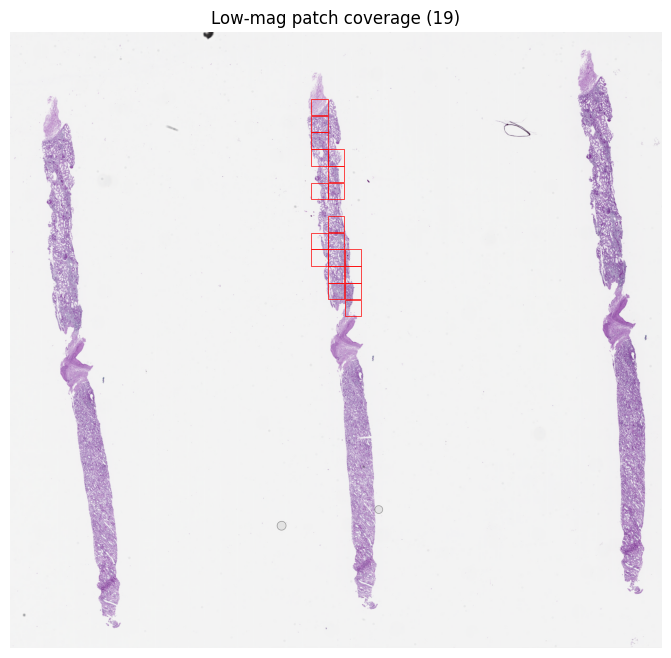

slides(xml): 100%|██████████| 43/43 [01:34<00:00,  2.21s/it]

[DONE] All slides processed.


In [30]:
def main():
    # =========================
    # CONFIG
    #   Inflammation (dataset/Annotation/Inflammation)
    #     Id == 1 -> Inflammation
    #     Id == 2 -> Inflammation control
    # =========================
    MAG_TO_LEVEL = {
    40.0: 0,
    10.0: 1,
    2.5:  2,
    }
    SVS_DIR = Path("/home/khdp-user/workspace/dataset/Slide")
    XML_DIR = Path("/home/khdp-user/workspace/dataset/Annotation/Inflammation")
    OUT_DIR = Path("/home/khdp-user/workspace/Infla_patch")
    BASE_MAG      = 40.0
    PATCH_SIZE    = 512
    STRIDE        = 512
    TARGET_MAG    = 10.0
    MASK_BASE_MAG = 2.5
    OVERLAP_TH    = 0.05
    LAYER_IDS = [1]
    VISUALIZE_FIRST = True
    OUT_DIR.mkdir(parents=True, exist_ok=True)
    xml_list = sorted(XML_DIR.glob("*.xml"))
    if len(xml_list) == 0:
        raise RuntimeError("No XML files found.")
    ALLOWED_MAGS = set(MAG_TO_LEVEL.keys())
    if TARGET_MAG not in ALLOWED_MAGS:
        raise ValueError(
            f"TARGET_MAG={TARGET_MAG} is not supported. "
            f"Allowed magnifications: {sorted(ALLOWED_MAGS)}"
        )
    
    if MASK_BASE_MAG not in ALLOWED_MAGS:
        raise ValueError(
            f"MASK_BASE_MAG={MASK_BASE_MAG} is not supported. "
            f"Allowed magnifications: {sorted(ALLOWED_MAGS)}"
        )
    # =========================
    # XML → SVS loop
    # =========================
    for xml_path in tqdm(xml_list, desc="slides(xml)"):

        svs_path = SVS_DIR / f"{xml_path.stem}.svs"
        if not svs_path.exists():
            continue

        name_ = svs_path.stem[:14]
        slide = openslide.OpenSlide(str(svs_path))

        # -------------------------
        # magnification
        # -------------------------
        lvl_img, scale_img, BASE_MAG = pick_level_for_target_mag(slide, TARGET_MAG)

        # -------------------------
        # mask base grid
        # -------------------------
        downsample = int(round(BASE_MAG / MASK_BASE_MAG))
        W0, H0 = slide.level_dimensions[0]
        mask_shape = (H0 // downsample, W0 // downsample)

        # -------------------------
        # XML → layer별 mask
        # -------------------------
        layer_masks = rasterize_xml_to_layer_masks(
            xml_path=xml_path,
            mask_shape=mask_shape,
            layer_ids=LAYER_IDS,
            downsample=downsample,
        )

        union_mask = np.zeros(mask_shape, np.uint8)
        for lid in LAYER_IDS:
            union_mask |= layer_masks[lid]

        Hm, Wm = union_mask.shape

        # -------------------------
        # output dirs
        # -------------------------
        slide_dir = OUT_DIR / name_
        img_dir   = slide_dir / "images"
        mask_root = slide_dir / "masks"

        img_dir.mkdir(parents=True, exist_ok=True)
        for lid in LAYER_IDS:
            (mask_root / f"layer{lid}").mkdir(parents=True, exist_ok=True)

        # -------------------------
        # patch loop
        # -------------------------
        xy_list = []
        stride_mask = int(round(STRIDE * (MASK_BASE_MAG / TARGET_MAG)))
        patch_mask_size = int(round(PATCH_SIZE * (MASK_BASE_MAG / TARGET_MAG)))
        for y in range(0, Hm, stride_mask):
            for x in range(0, Wm, stride_mask):
                if x + patch_mask_size >= Wm or y + patch_mask_size >= Hm:
                    continue
                patch_union = union_mask[y:y+patch_mask_size, x:x+patch_mask_size]
                overlap = np.count_nonzero(patch_union) / patch_union.size

                if overlap < OVERLAP_TH:
                    continue

                xy_list.append((x, y))

                x0 = x * downsample
                y0 = y * downsample

                req = int(round(PATCH_SIZE * scale_img))
                region = slide.read_region((x0, y0), lvl_img, (req, req))

                img = cv2.resize(
                    np.array(region)[:, :, :3],
                    (PATCH_SIZE, PATCH_SIZE),
                    interpolation=cv2.INTER_LINEAR,
                )

                out_name = f"{name_}_X0Y0_{x0:06d}_{y0:06d}.png"

                cv2.imwrite(
                    str(img_dir / out_name),
                    cv2.cvtColor(img, cv2.COLOR_RGB2BGR),
                )
                # layer별 mask 저장
                for lid in LAYER_IDS:
                    mp = layer_masks[lid][y:y+patch_mask_size, x:x+patch_mask_size]
                    if TARGET_MAG != MASK_BASE_MAG:
                        mp = cv2.resize(
                            mp,
                            (PATCH_SIZE, PATCH_SIZE),
                            interpolation=cv2.INTER_NEAREST,
                        )

                    if np.count_nonzero(mp) == 0:
                        continue

                    cv2.imwrite(
                        str(mask_root / f"layer{lid}" / out_name),
                        (mp * 255).astype(np.uint8),
                    )

        if VISUALIZE_FIRST and len(xy_list) > 0:
            lvl_vis = min(lvl_img + 2, slide.level_count - 1)
            Wv, Hv = slide.level_dimensions[lvl_vis]

            rgb_mask = np.array(
                slide.read_region((0, 0), lvl_vis, (Wv, Hv))
            )[:, :, :3]

            xy_vis = []
            for (x_mask, y_mask) in xy_list:
                x_lv0 = x_mask * downsample
                y_lv0 = y_mask * downsample
                x_vis = int(x_lv0 / slide.level_downsamples[lvl_vis])
                y_vis = int(y_lv0 / slide.level_downsamples[lvl_vis])
                xy_vis.append((x_vis, y_vis))

            patch_vis = int(
                (patch_mask_size * downsample) / slide.level_downsamples[lvl_vis]
            )
            visualize_patch_boxes_lowmag(
                rgb_mask=rgb_mask,
                xy_mask=xy_vis,
                patch_mask=patch_vis,
            )

            VISUALIZE_FIRST = False

        slide.close()

    print("[DONE] All slides processed.")

if __name__ == "__main__":
    main()

# 5Y outcome 학습용 Core 추출

In [ ]:
def main():
    # =========================
    # CONFIG
    #   Glom segmentation (dataset/Annotation/Glmerulus)
    #     Id == 1 -> Core ROI
    #     Id == 2 -> Glomerulus
    # =========================
    MAG_TO_LEVEL = {
    40.0: 0,
    10.0: 1,
    2.5:  2,
    }
    SVS_DIR = Path("/home/khdp-user/workspace/dataset/Slide")
    XML_DIR = Path("/home/khdp-user/workspace/dataset/Annotation/Glomerulus")
    OUT_DIR = Path("/home/khdp-user/workspace/MIL_patch")
    BASE_MAG      = 40.0
    PATCH_SIZE    = 512
    STRIDE        = 512
    TARGET_MAG    = 10.0
    MASK_BASE_MAG = 2.5
    OVERLAP_TH    = 0.3
    LAYER_IDS = [1]
    VISUALIZE_FIRST = True
    OUT_DIR.mkdir(parents=True, exist_ok=True)
    xml_list = sorted(XML_DIR.glob("*.xml"))
    if len(xml_list) == 0:
        raise RuntimeError("No XML files found.")
    ALLOWED_MAGS = set(MAG_TO_LEVEL.keys())
    if TARGET_MAG not in ALLOWED_MAGS:
        raise ValueError(
            f"TARGET_MAG={TARGET_MAG} is not supported. "
            f"Allowed magnifications: {sorted(ALLOWED_MAGS)}"
        )
    
    if MASK_BASE_MAG not in ALLOWED_MAGS:
        raise ValueError(
            f"MASK_BASE_MAG={MASK_BASE_MAG} is not supported. "
            f"Allowed magnifications: {sorted(ALLOWED_MAGS)}"
        )
    # =========================
    # XML → SVS loop
    # =========================
    for xml_path in tqdm(xml_list, desc="slides(xml)"):

        svs_path = SVS_DIR / f"{xml_path.stem}.svs"
        if not svs_path.exists():
            continue

        name_ = svs_path.stem[:14]
        slide = openslide.OpenSlide(str(svs_path))

        # -------------------------
        # magnification
        # -------------------------
        lvl_img, scale_img, BASE_MAG = pick_level_for_target_mag(slide, TARGET_MAG)

        # -------------------------
        # mask base grid
        # -------------------------
        downsample = int(round(BASE_MAG / MASK_BASE_MAG))
        W0, H0 = slide.level_dimensions[0]
        mask_shape = (H0 // downsample, W0 // downsample)

        # -------------------------
        # XML → layer별 mask
        # -------------------------
        layer_masks = rasterize_xml_to_layer_masks(
            xml_path=xml_path,
            mask_shape=mask_shape,
            layer_ids=LAYER_IDS,
            downsample=downsample,
        )

        union_mask = np.zeros(mask_shape, np.uint8)
        for lid in LAYER_IDS:
            union_mask |= layer_masks[lid]

        Hm, Wm = union_mask.shape

        # -------------------------
        # output dirs
        # -------------------------
        slide_dir = OUT_DIR / name_
        img_dir   = slide_dir / "images"
        mask_root = slide_dir / "masks"

        img_dir.mkdir(parents=True, exist_ok=True)
        for lid in LAYER_IDS:
            (mask_root / f"layer{lid}").mkdir(parents=True, exist_ok=True)

        # -------------------------
        # patch loop
        # -------------------------
        xy_list = []
        stride_mask = int(round(STRIDE * (MASK_BASE_MAG / TARGET_MAG)))
        patch_mask_size = int(round(PATCH_SIZE * (MASK_BASE_MAG / TARGET_MAG)))
        for y in range(0, Hm, stride_mask):
            for x in range(0, Wm, stride_mask):
                if x + patch_mask_size >= Wm or y + patch_mask_size >= Hm:
                    continue
                patch_union = union_mask[y:y+patch_mask_size, x:x+patch_mask_size]
                overlap = np.count_nonzero(patch_union) / patch_union.size

                if overlap < OVERLAP_TH:
                    continue

                xy_list.append((x, y))

                x0 = x * downsample
                y0 = y * downsample

                req = int(round(PATCH_SIZE * scale_img))
                region = slide.read_region((x0, y0), lvl_img, (req, req))

                img = cv2.resize(
                    np.array(region)[:, :, :3],
                    (PATCH_SIZE, PATCH_SIZE),
                    interpolation=cv2.INTER_LINEAR,
                )

                out_name = f"{name_}_X0Y0_{x0:06d}_{y0:06d}.png"

                cv2.imwrite(
                    str(img_dir / out_name),
                    cv2.cvtColor(img, cv2.COLOR_RGB2BGR),
                )
                # layer별 mask 저장
                for lid in LAYER_IDS:
                    mp = layer_masks[lid][y:y+patch_mask_size, x:x+patch_mask_size]
                    if TARGET_MAG != MASK_BASE_MAG:
                        mp = cv2.resize(
                            mp,
                            (PATCH_SIZE, PATCH_SIZE),
                            interpolation=cv2.INTER_NEAREST,
                        )

                    if np.count_nonzero(mp) == 0:
                        continue

                    cv2.imwrite(
                        str(mask_root / f"layer{lid}" / out_name),
                        (mp * 255).astype(np.uint8),
                    )

        if VISUALIZE_FIRST and len(xy_list) > 0:
            lvl_vis = min(lvl_img + 2, slide.level_count - 1)
            Wv, Hv = slide.level_dimensions[lvl_vis]

            rgb_mask = np.array(
                slide.read_region((0, 0), lvl_vis, (Wv, Hv))
            )[:, :, :3]

            xy_vis = []
            for (x_mask, y_mask) in xy_list:
                x_lv0 = x_mask * downsample
                y_lv0 = y_mask * downsample
                x_vis = int(x_lv0 / slide.level_downsamples[lvl_vis])
                y_vis = int(y_lv0 / slide.level_downsamples[lvl_vis])
                xy_vis.append((x_vis, y_vis))

            patch_vis = int(
                (patch_mask_size * downsample) / slide.level_downsamples[lvl_vis]
            )
            visualize_patch_boxes_lowmag(
                rgb_mask=rgb_mask,
                xy_mask=xy_vis,
                patch_mask=patch_vis,
            )

            VISUALIZE_FIRST = False

        slide.close()

    print("[DONE] All slides processed.")

if __name__ == "__main__":
    main()

slides(xml):   0%|          | 0/764 [00:00<?, ?it/s]